# Conditional DDPM на MNIST

Учебная реализация диффузионной модели с управляемой генерацией цифр (0-9).

In [86]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import math
import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Загрузка MNIST

In [87]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 2. - 1.)
])

dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

## Шумовое расписание

In [88]:
T = 1000
betas = torch.linspace(1e-4, 0.02, T).to(device)
alphas = 1. - betas
alpha_bars = torch.cumprod(alphas, dim=0).to(device)

## Эмбеддинги времени и класса

In [89]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        emb = torch.exp(-torch.arange(half_dim, device=device) * (math.log(10000) / (half_dim - 1)))
        emb = t[:, None] * emb[None, :]
        
        return torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)

## Модель (упрощённый U-Net)

In [90]:
class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, emb_ch):
        super().__init__()
        self.norm1 = nn.GroupNorm(8, in_ch)
        self.act1 = nn.SiLU()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)

        self.norm2 = nn.GroupNorm(8, out_ch)
        self.act2 = nn.SiLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)

        self.emb_proj = nn.Linear(emb_ch, out_ch)
        self.skip = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, emb):
        h = self.conv1(self.act1(self.norm1(x)))
        emb_out = self.emb_proj(emb)[:, :, None, None]
        h = h + emb_out
        h = self.conv2(self.act2(self.norm2(h)))
        
        return h + self.skip(x)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch, emb_ch):
        super().__init__()
        self.block = ResBlock(in_ch, out_ch, emb_ch)
        self.pool = nn.AvgPool2d(2)

    def forward(self, x, emb):
        x = self.block(x, emb)
        
        return self.pool(x), x

class Up(nn.Module):
    def __init__(self, x_ch, skip_ch, out_ch, emb_ch):
        super().__init__()
        self.block = ResBlock(x_ch + skip_ch, out_ch, emb_ch)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x, skip, emb):
        x = self.upsample(x)
        x = torch.cat([x, skip], dim=1)
        
        return self.block(x, emb)


class ConditionalUNet(nn.Module):
    def __init__(self, num_classes=10, base_ch=64):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(32),
            nn.Linear(32, base_ch * 4),
            nn.SiLU(),
            nn.Linear(base_ch * 4, base_ch * 4)
        )
        self.label_emb = nn.Embedding(num_classes, base_ch * 4)

        self.init_conv = nn.Conv2d(1, base_ch, 3, padding=1)

        self.down1 = Down(base_ch, base_ch * 2, base_ch * 4)
        self.down2 = Down(base_ch * 2, base_ch * 4, base_ch * 4)

        self.bot = ResBlock(base_ch * 4, base_ch * 4, base_ch * 4)

        self.up2 = Up(base_ch * 4, base_ch * 4, base_ch * 2, base_ch * 4)
        self.up1 = Up(base_ch * 2, base_ch * 2, base_ch, base_ch * 4)

        self.out_conv = nn.Sequential(
            nn.GroupNorm(8, base_ch),
            nn.SiLU(),
            nn.Conv2d(base_ch, 1, 3, padding=1)
        )

    def forward(self, x, t, y):
        temb = self.time_mlp(t)
        yemb = self.label_emb(y)
        emb = temb + yemb

        x = self.init_conv(x)
        x1_in = x
        x2_in, skip1 = self.down1(x1_in, emb)
        x3_in, skip2 = self.down2(x2_in, emb)
        x_mid = self.bot(x3_in, emb)
        x = self.up2(x_mid, skip2, emb)
        x = self.up1(x, skip1, emb)
        
        return self.out_conv(x)


## Функция q_sample

In [91]:
def q_sample(x_0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_0)
        
    sqrt_alpha_bar = alpha_bars[t][:, None, None, None].sqrt()
    sqrt_one_minus = (1 - alpha_bars[t])[:, None, None, None].sqrt()
    
    return sqrt_alpha_bar * x_0 + sqrt_one_minus * noise


## Обучение

In [ ]:
epochs = 50
model = ConditionalUNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(epochs):
    for x, y in tqdm.tqdm(dataloader):
        x = x.to(device)
        y = y.to(device)
        t = torch.randint(0, T, (x.size(0),), device=device).long()
        noise = torch.randn_like(x)
        x_t = q_sample(x, t, noise)
        pred_noise = model(x_t, t, y)
        loss = F.mse_loss(pred_noise, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f"Epoch {epoch}: loss = {loss.item():.4f}")

## Генерация цифр по классу

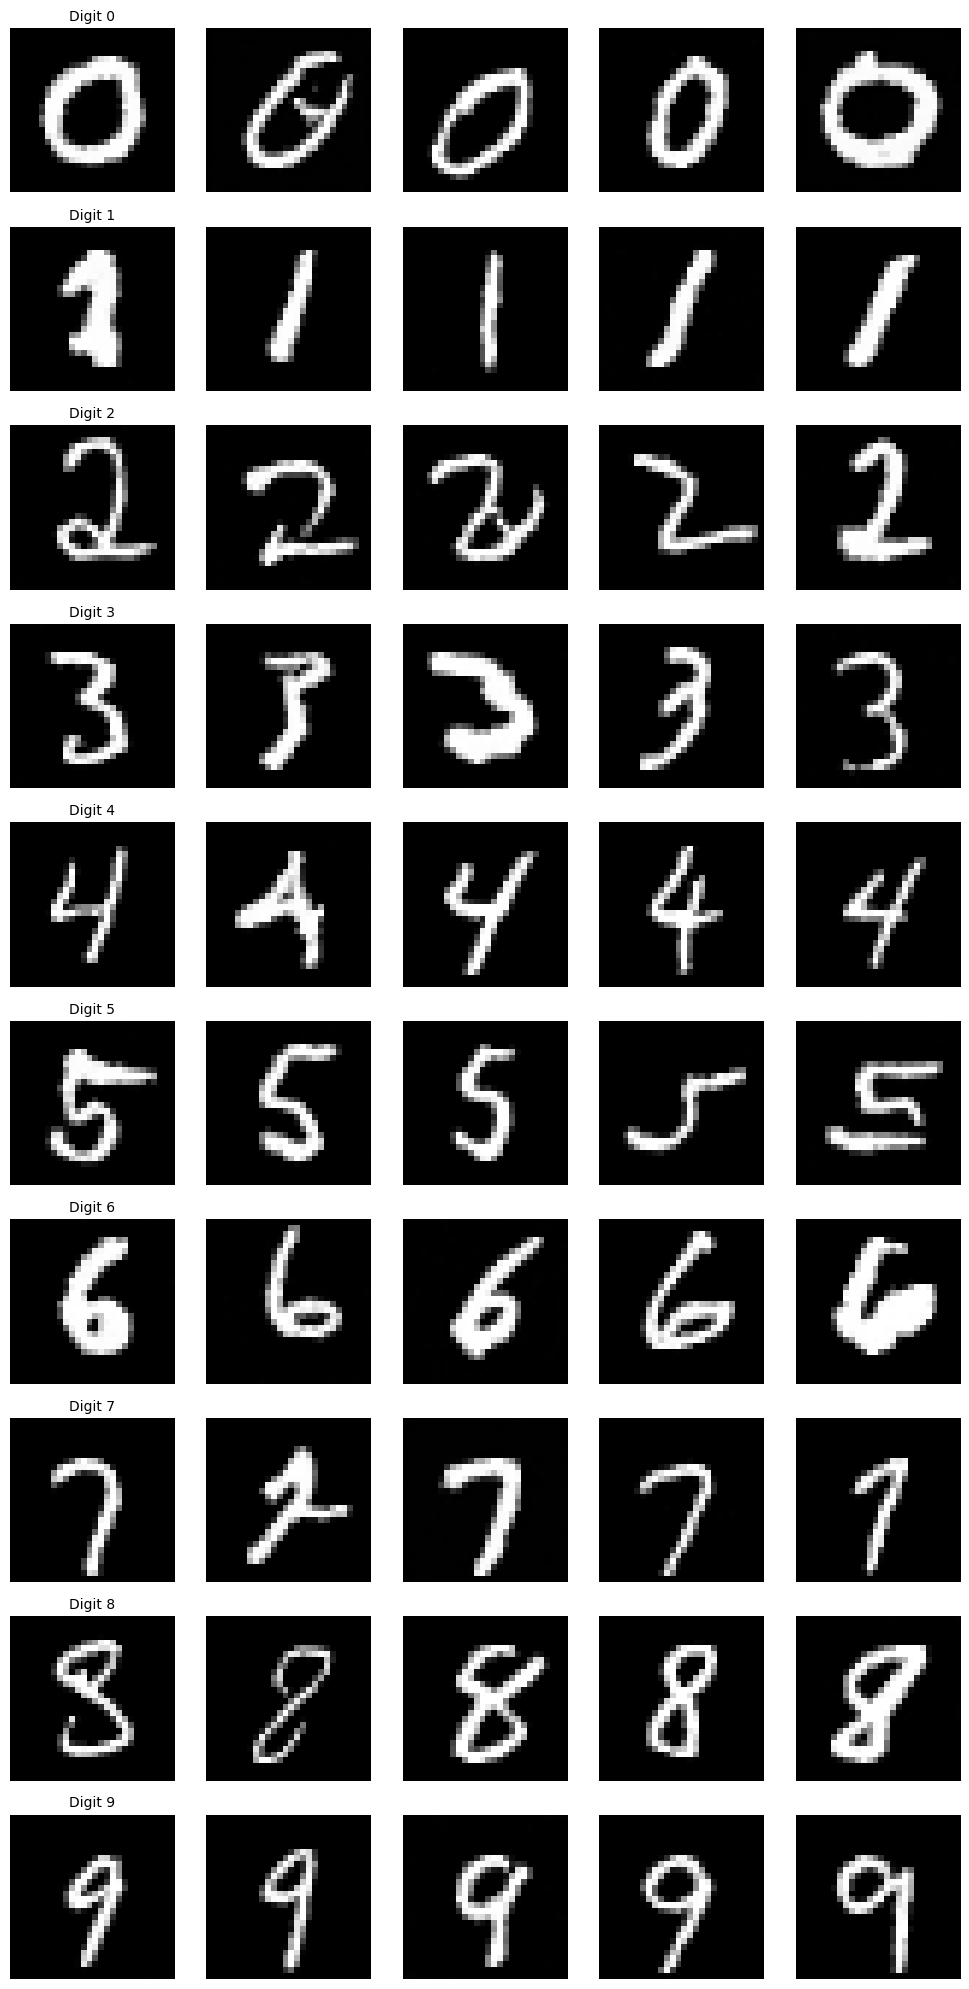

In [97]:
@torch.no_grad()
def sample_digit(label, model, steps=T):
    model.eval()
    x = torch.randn(1, 1, 28, 28).to(device)
    y = torch.tensor([label], device=device)
    
    for t_ in reversed(range(steps)):
        t = torch.full((1,), t_, device=device, dtype=torch.long)
        noise_pred = model(x, t, y)
        beta = betas[t_]
        alpha = alphas[t_]
        alpha_bar = alpha_bars[t_]
        
        if t_ > 0:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)
            
        x = (1 / alpha.sqrt()) * (x - ((1 - alpha) / (1 - alpha_bar).sqrt()) * noise_pred) + beta.sqrt() * noise
        
    return x

num_digits = 10
samples_per_digit = 5

fig, axes = plt.subplots(num_digits, samples_per_digit, figsize=(samples_per_digit * 2, num_digits * 2))

for digit in range(num_digits):
    for i in range(samples_per_digit):
        generated = sample_digit(digit, model)
        img = generated.cpu().squeeze().clamp(-1, 1).add(1).div(2)

        ax = axes[digit, i]
        ax.imshow(img, cmap='gray')
        ax.axis("off")
        if i == 0:
            ax.set_title(f"Digit {digit}", fontsize=10)

plt.tight_layout()
plt.show()